In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers,Sequential
import tensorflow as tf
import os

In [2]:
path_to_file =  tf.keras.utils.get_file('shakesphere.txt','https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [3]:
#Read, then decode for py2 compact
text = open (path_to_file,'rb').read().decode(encoding = 'utf-8')

In [4]:
len(text)

1115394

In [5]:
#Take a look at the first 250 words
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [6]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Process the dataset

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [7]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [8]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [9]:
#show how the first 13 character from the text are mapped to integer
text_as_int = np.array([char2index[char] for char in text])
print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 1115394
'First Citizen:\n' --> array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0])


In [10]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [11]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

F
i
r
s
t


In [12]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 11043

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [13]:
def split_image_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text,target_text


In [14]:
dataset = sequences.map(split_image_target)


In [15]:
for input_example,target_example in dataset.take(1):
  print('Input:', repr(''.join(index2char[input_example.numpy()])))
  print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [16]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 18 ('F')
  expected output: 47 ('i')
Step  1
  input: 47 ('i')
  expected output: 56 ('r')
Step  2
  input: 56 ('r')
  expected output: 57 ('s')
Step  3
  input: 57 ('s')
  expected output: 58 ('t')
Step  4
  input: 58 ('t')
  expected output: 1 (' ')


## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [17]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Build a Model

Use [tf.keras.Sequential] to define the model. For this simple example three layers are used to define our model:

- `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- `tf.keras.layers.LSTM`: A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
- `tf.keras.layers.Dense:` The output layer, with vocab_size outputs.

In [18]:
#Length of the vocabulary in chars
vocab_size = len(vocab)

#The embedding dimension
embedding_dim = 256

# Number of RNN units

rnn_units = 1024

In [19]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True, #for output from each node
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal() #special RNN intializer
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model

In [20]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           16640     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 65)            66625     
                                                                 
Total params: 5330241 (20.33 MB)
Trainable params: 5330241 (20.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


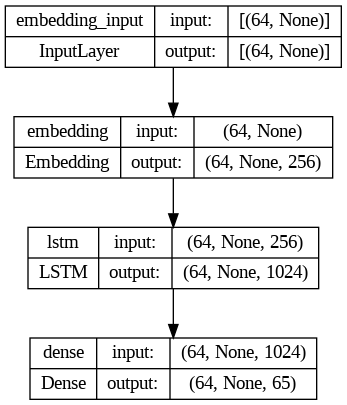

In [22]:
# Plot the model architecture.
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)


For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:


## Try the Model

In [23]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.?

### Attach an optimizer, and a loss function

In [24]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.1741147


In [25]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configure checkpoints

In [26]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [27]:
history = model.fit(
  x=dataset,
  epochs=50,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/50
172/172 [==============================] - 23s 79ms/step - loss: 2.5781
Epoch 2/50
172/172 [==============================] - 14s 71ms/step - loss: 1.8776
Epoch 3/50
172/172 [==============================] - 14s 71ms/step - loss: 1.6275
Epoch 4/50
172/172 [==============================] - 14s 71ms/step - loss: 1.4954
Epoch 5/50
172/172 [==============================] - 14s 70ms/step - loss: 1.4166
Epoch 6/50
172/172 [==============================] - 15s 70ms/step - loss: 1.3607
Epoch 7/50
172/172 [==============================] - 15s 71ms/step - loss: 1.3167
Epoch 8/50
172/172 [==============================] - 14s 72ms/step - loss: 1.2776
Epoch 9/50
172/172 [==============================] - 14s 71ms/step - loss: 1.2415
Epoch 10/50
172/172 [==============================] - 15s 69ms/step - loss: 1.2067
Epoch 11/50
172/172 [==============================] - 13s 69ms/step - loss: 1.1706
Epoch 12/50
172/172 [==============================] - 14s 70ms/step - loss: 1.1335
E

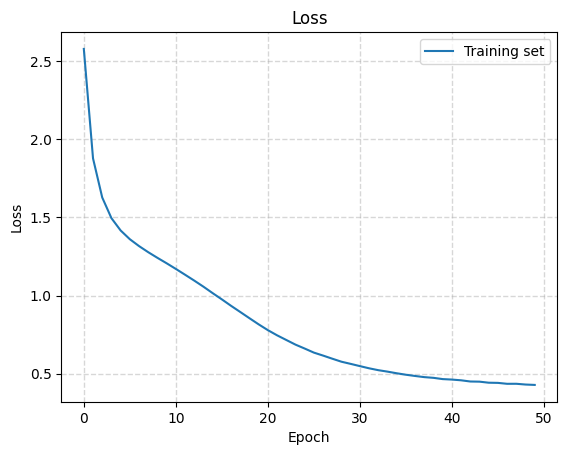

In [28]:
#plot the graph
loss = history.history['loss']
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

## Generate the Text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [29]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_50'

In [30]:
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            16640     
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 65)             66625     
                                                                 
Total params: 5330241 (20.33 MB)
Trainable params: 5330241 (20.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.


In [32]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [33]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: Most mayor what a shrive beholding Ress!

KING RICHARD II:
Think we as fam asleep; that the gods will follow:
Richard be here--all great Lord of Gloucester?

Lord Wal suspect, worse:
Thou wast a Richard, till a Richard kill'd him;
I had a bride than eat: therefore bring forth, I stand to the gods preserve me.

QUEEN ELIZABETH:
Come, bring alone, black, which art thou yet to quesion; then, belike, I
Just in the bloody of the west,
And no less things goes there.

BENVOLIO:
If thou wert son: have you ng.

BIONDELLO:
Then mutake herse sleepe as great as well
I cannot speak, neither meet we are all have I in the right Vincentio;
The prince your son, their back again,
And make paid the boar succress the two?

DUKE VINCENTIO:
The best adversaries and mine, are worth preparent.
O, he, my lord, wish me in life the beastly I know;
Our general guess,
Like twenty of their sleghat calls me.

First Gentleman:
What, do you not?

Nurse:

JULIET:
Must die to-morrow! O injurious villain!
Kit unno